In [15]:
import pandas as pd
import numpy as np

csv_path = '../../Binance_Merge_OI_Taker.csv'

df = pd.read_csv(csv_path)

df

df['price_chg']=df['close'].pct_change()
df['taker_rati'] = df['taker_sel_buy_ratio'] 
df['oi'] = df['open_interest'] 
df


,start_time,close,longShortRatio,shortAccount,longAccount,datetime,open_interest,price_chg,longshort,oi_ls
0,2022-07-28 09:00:00,22974.4,0.857,53.86,46.14,2022-07-28 09:00:00,2.592844e+09,NaN,-7.72,-2.001676e+10
1,2022-07-28 10:00:00,22974.4,0.825,54.79,45.21,2022-07-28 10:00:00,2.587433e+09,0.000000,-9.58,-2.478761e+10
2,2022-07-28 11:00:00,23106.0,0.858,53.83,46.17,2022-07-28 11:00:00,2.599680e+09,0.005728,-7.66,-1.991355e+10
3,2022-07-28 12:00:00,23029.2,0.885,53.04,46.96,2022-07-28 12:00:00,2.577875e+09,-0.003324,-6.08,-1.567348e+10
4,2022-07-28 13:00:00,22841.8,0.801,55.53,44.47,2022-07-28 13:00:00,2.565135e+09,-0.008137,-11.06,-2.837039e+10
...,...,...,...,...,...,...,...,...,...,...
15418,2024-04-30 19:00:00,59276.2,3.037,24.77,75.23,2024-04-30 19:00:00,4.376545e+09,-0.018411,50.46,2.208405e+11
15419,2024-04-30 20:00:00,59931.8,3.037,24.77,75.23,2024-04-30 20:00:00,4.395567e+09,0.011060,50.46,2.218003e+11
15420,2024-04-30 21:00:00,60149.2,3.182,23.91,76.09,2024-04-30 21:00:00,4.403951e+09,0.003627,52.18,2.297982e+11
15421,2024-04-30 22:00:00,60561.0,3.182,23.91,76.09,2024-04-30 22:00:00,4.383593e+09,0.006846,52.18,2.287359e+11


In [24]:
def backtesting(rolling_window, multiplier, sr_multiplier, fees, backtest_mode):
    df['sma'] = df['oi_ls'].rolling(window=rolling_window).mean()
    sma = df['sma'].values
    
    # sma=np.nan_to_num(sma_sma)

    upper_sma_threshold =[]
    lower_sma_threshold =[]
    for i in range(0,len(df)):
        if sma[i] > 0.0:
            upper_sma_threshold.append(sma[i] * (1.0 + multiplier))
            lower_sma_threshold.append(sma[i] * (1.0 - multiplier))
        else:
            upper_sma_threshold.append(sma[i] * (1.0 - multiplier))
            lower_sma_threshold.append(sma[i] * (1.0 + multiplier))
        
    
    df['upper']=upper_sma_threshold
    df['lower']=lower_sma_threshold

    position = np.array([0.0] * len(df))

    # position entry exit logic
    long_trade = 0
    short_trade = 0
    # loopp all the zscore for entry and exit based on threshold
    if backtest_mode == "trend":
        for i in range(1, len(position)):
            if df['oi_ls'][i] >= upper_sma_threshold[i]:
                position[i] = 1
                # previous position = 0 or -1 , current position = 1
                if position[i-1] != position[i]:
                    long_trade += 1

            elif df['oi_ls'][i] <= lower_sma_threshold[i]: # 1 * -1.0 = -1
                position[i] = -1
                # previous position = 1 or 0, current position = -1
                if position[i-1] != position[i]:
                    short_trade += 1

            # elif df['oi_ls'][i] <= sma[i] and position [i-1] == 1:
            #     position [i] = 0

            # elif df['oi_ls'][i] >= sma[i] and position [i-1] == -1:
            #     position [i] = 0

            else:
                position[i] = position[i-1] # previous position = 1, current position = 1

            # else:
            #     position [i] = 0
    else:
        for i in range(1, len(position)):
            if df['oi_ls'][i] >= upper_sma_threshold[i]:
                position[i] = -1
                # previous position = 1 or 0, current position = -1
                if position[i-1] != position[i]:
                    short_trade += 1

            elif df['oi_ls'][i] <= lower_sma_threshold[i]: # 1 * -1.0 = -1
                position[i] = 1
                # previous position = 0 or -1 , current position = 1
                if position[i-1] != position[i]:
                    long_trade += 1

            # elif df['oi_ls'][i] <= sma[i] and position [i-1] == -1:
            #     position [i] = 0

            # elif df['oi_ls'][i] >= sma[i] and position [i-1] == 1:
            #     position [i] = 0

            else:
                position[i] = position[i-1] # previous position = 1, current position = 1
            
            # else :
            #     position [i] =0


    # trades and pnl calculation
    # After done entry and exit logic
    # Calculate performance 
    interval_pnl = [0]
    trades = [0]

    # trades = np.array([0.0] * len(df))
    # get the trades
    for i in range(1,len(df)):
        # if previous position is not same as current position , mean got trade executed
        # example, previous position = 0, current position = -1 , trades = 0 - (-1) = 1
        # previous position = 0, current position = 1 , trades = 0 - 1 = abs(-1) = 1
        # previous position = 1, current position = -1 , trades = 1 - (-1) = abs(2) = 2
        # previous position = -1, current position = 1 , trades = -1 - 1 = abs(-2) = 2
        if position[i-1] != position[i]:
            trades.append(abs(position[i-1] - position[i]))
        else:
            trades.append(0)
    # calculate the PnL by using trades and position, and also fees 
    price_change = df['price_chg'].values
    for i in range(1,len(df)):
        interval_pnl.append(position[i-1] * price_change[i] - trades[i] * fees / 100)
    df['pnl'] = interval_pnl
    df['position'] = position
    df['trade'] = trades
    df['cumu'] = df['pnl'].cumsum()
    df['dd'] = df['cumu'] - df['cumu'].cummax()

    # mdd = df['dd'].min
    dd= df['dd'].values
    mdd = min(dd)

    # performance report
    # mdd = min(interval_pnl)
    # mean of PnL
    mean = np.mean(interval_pnl)
    # standard deviation of PnL
    stddev = np.std(interval_pnl)

    # SR multiplier => daily data = 365 * 1
    #                  1 hour data = 365 * 24
    # Sharpe ratio = mean of pnl / std of pnl * square root of (365 * sr_multiplier)
    sharpe_ratio = mean / stddev * np.sqrt(365 * sr_multiplier)
    # Performance report
    data = {
            'rolling_window': rolling_window,
            'multiplier': multiplier,
            'num_of_trades': np.sum(trades),
            'long_trades': long_trade,
            'short_trades': short_trade,
            'cumu': df['cumu'].iat[-1],
            'AR': mean * 365 * sr_multiplier,
            'MDD': mdd,
            'CR': mean * 365 * sr_multiplier / abs(mdd),
            'SR': sharpe_ratio 
        }

    return data


trend


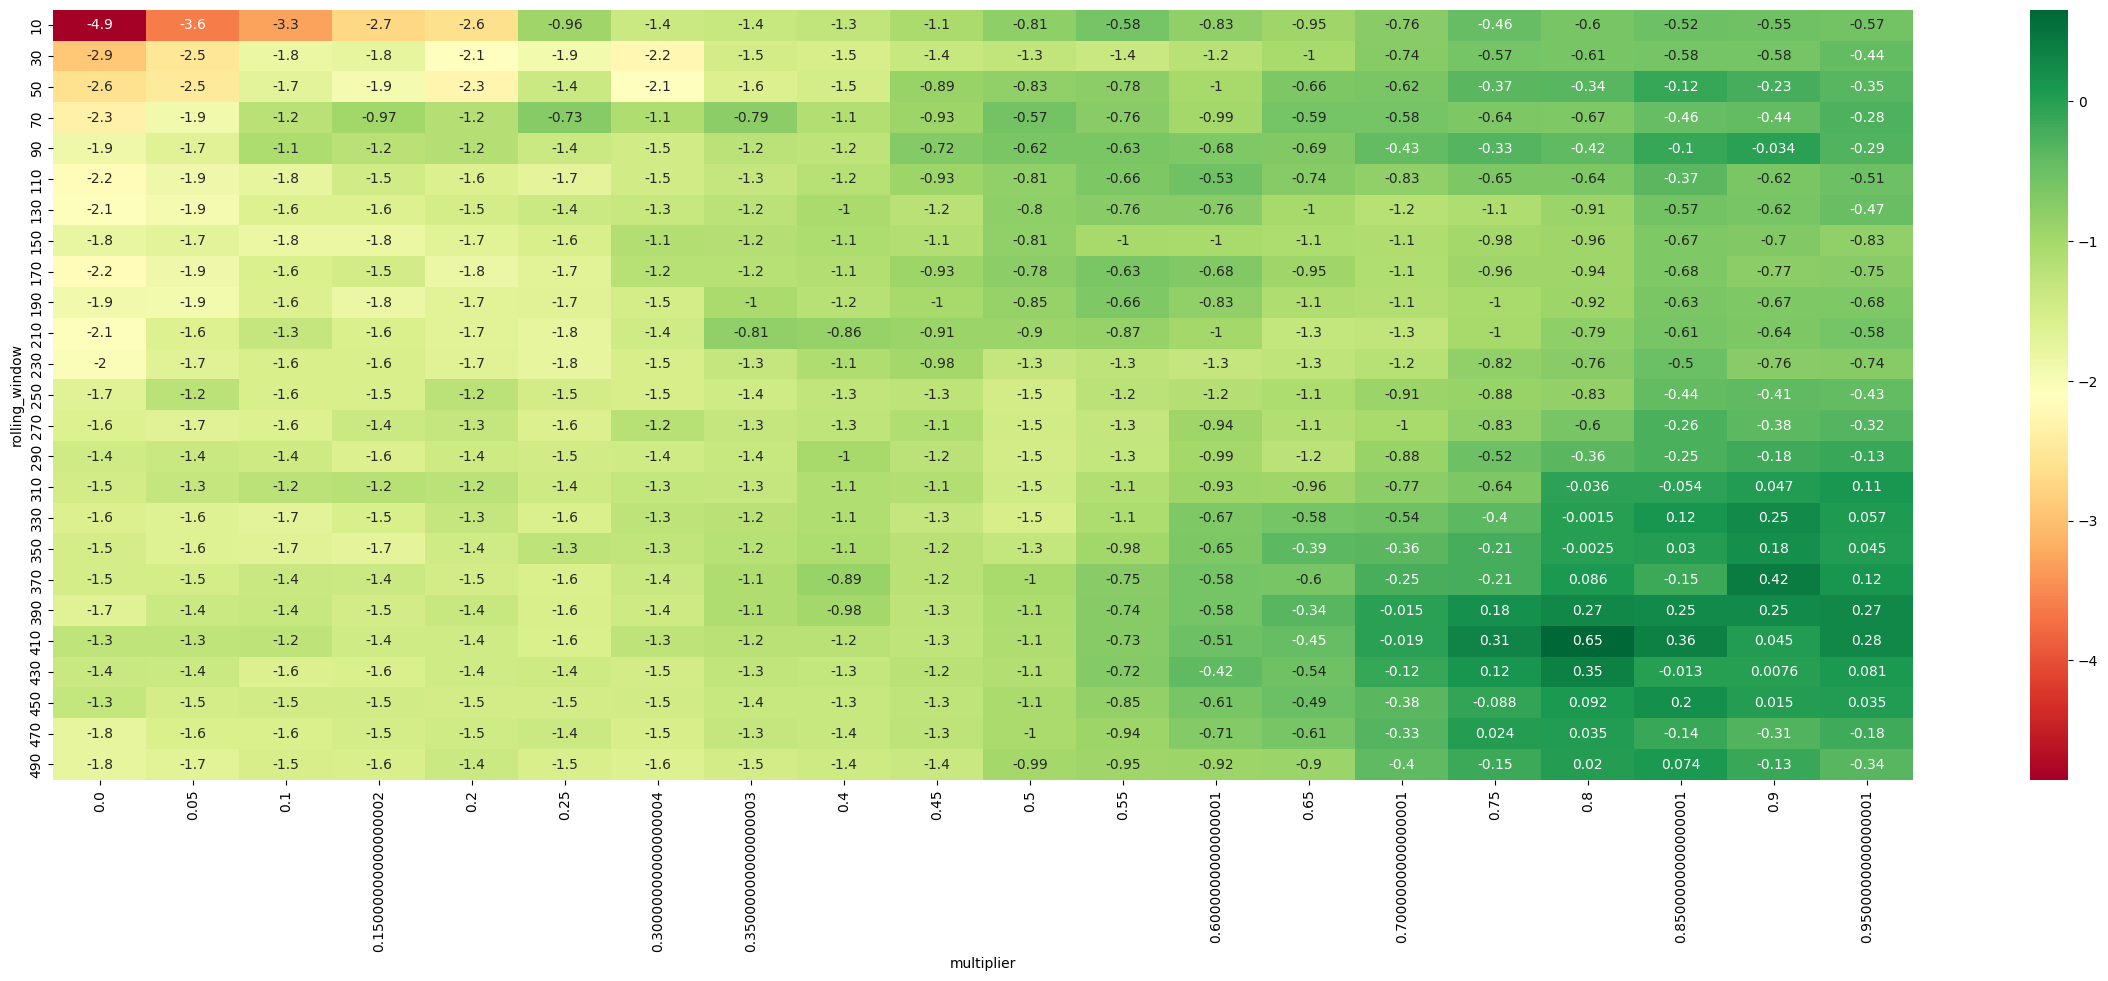

mr


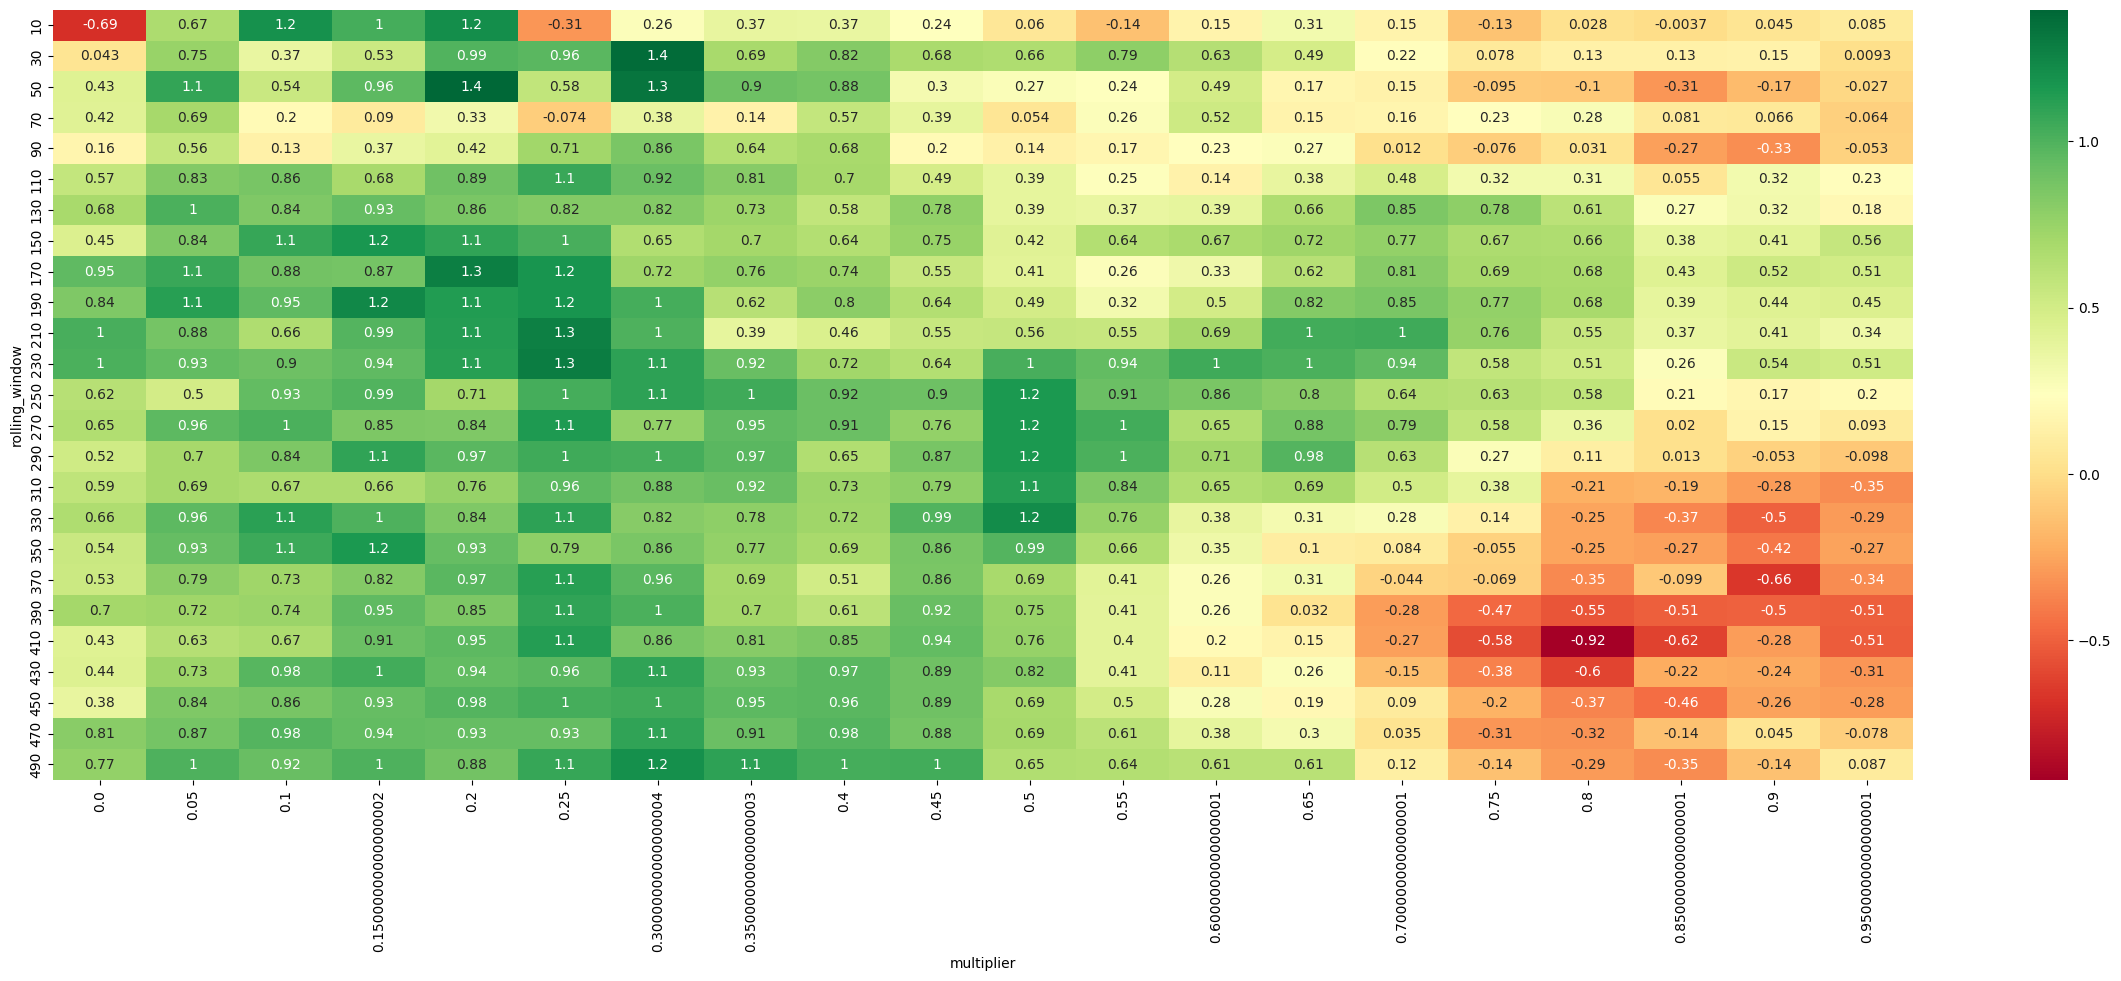

In [25]:
# loop all params needed to backtest 
rolling_window_array = np.arange(10, 500, 20)
z_score_threshold_array = np.arange(0, 1, 0.05)
backtest_mode_arr = ["trend", "mr"]
for backtest_mode in backtest_mode_arr:
    print(backtest_mode)
    all_result = []
    for rolling_window in rolling_window_array:
        for z_score_threshold in z_score_threshold_array:
            backtest_1 = backtesting(rolling_window=rolling_window, multiplier=z_score_threshold, sr_multiplier=24, fees=0.06, backtest_mode=backtest_mode)
            # print(backtest_1)
            all_result.append(backtest_1)
    all_sr = pd.DataFrame(all_result)
    df_pivot = all_sr.pivot(index="rolling_window",columns ='multiplier', values="SR")
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Create a heatmap
    plt.figure(figsize=(30, 10))
    sns.heatmap(df_pivot,annot=True, cmap='RdYlGn')
    # Show the plot
    plt.show()

In [8]:
backtesting(230,0.25,24,0.06,'mr')

{'rolling_window': 230,
 'z_score_threshold': 0.25,
 'num_of_trades': 409.0,
 'long_trades': 102,
 'short_trades': 103,
 'cumu': 0.9036684031415152,
 'AR': 0.5132681846281297,
 'MDD': -0.4449011420761825,
 'CR': 1.1536679412260094,
 'SR': 1.0842727923350448}

In [7]:
def backtesting(rolling_window, z_score_threshold, sr_multiplier, fees, backtest_mode):
    # z_score calculation
    # df['oi_mc'] = df['open_interest'] / df['close']/df['market_cap']
    # rolling mean
    df['sma'] = df['oi_ls'].rolling(window=rolling_window).mean()
    # rolling std
    df['rolling_std'] = df['oi_ls'].rolling(window=rolling_window).std()
    # zscore = (closeprice - mean) / std
    df['z_score'] = (df['oi_ls'] - df['sma']) / df['rolling_std']
    # convert zscore into array and convert NaN to 0.0
    not_clean_z_score = df["z_score"].values
    z_score = np.nan_to_num(not_clean_z_score)
    position = np.array([0.0] * len(df))

    # position entry exit logic
    long_trade = 0
    short_trade = 0
    # loopp all the zscore for entry and exit based on z_score
    if backtest_mode == "trend":
        for i in range(1, len(position)):
            if z_score[i] >= z_score_threshold:
                position[i] = 1
                # previous position = 0 or -1 , current position = 1
                if position[i-1] != position[i]:
                    long_trade += 1
            elif z_score[i] <= z_score_threshold * -1.0: # 1 * -1.0 = -1
                position[i] = -1
                # previous position = 1 or 0, current position = -1
                if position[i-1] != position[i]:
                    short_trade += 1
            else:
                position[i] = position[i-1] # previous position = 1, current position = 1
    else:
        for i in range(1, len(position)):
            if z_score[i] >= z_score_threshold:
                position[i] = -1
                # previous position = 1 or 0, current position = -1
                if position[i-1] != position[i]:
                    short_trade += 1
            elif z_score[i] <= z_score_threshold * -1.0: # 1 * -1.0 = -1
                position[i] = 1
                # previous position = 0 or -1 , current position = 1
                if position[i-1] != position[i]:
                    long_trade += 1
            else:
                position[i] = position[i-1] # previous position = 1, current position = 1


    # trades and pnl calculation
    # After done entry and exit logic
    # Calculate performance 
    interval_pnl = [0]
    trades = [0]

    # trades = np.array([0.0] * len(df))
    # get the trades
    for i in range(1,len(df)):
        # if previous position is not same as current position , mean got trade executed
        # example, previous position = 0, current position = -1 , trades = 0 - (-1) = 1
        # previous position = 0, current position = 1 , trades = 0 - 1 = abs(-1) = 1
        # previous position = 1, current position = -1 , trades = 1 - (-1) = abs(2) = 2
        # previous position = -1, current position = 1 , trades = -1 - 1 = abs(-2) = 2
        if position[i-1] != position[i]:
            trades.append(abs(position[i-1] - position[i]))
        else:
            trades.append(0)
    # calculate the PnL by using trades and position, and also fees 
    price_change = df['price_chg'].values
    for i in range(1,len(df)):
        interval_pnl.append(position[i-1] * price_change[i] - trades[i] * fees / 100)
    df['pnl'] = interval_pnl
    df['position'] = position
    df['trade'] = trades
    df['cumu'] = df['pnl'].cumsum()
    df['dd'] = df['cumu'] - df['cumu'].cummax()

    # mdd = df['dd'].min
    dd= df['dd'].values
    mdd = min(dd)

    # performance report
    # mdd = min(interval_pnl)
    # mean of PnL
    mean = np.mean(interval_pnl)
    # standard deviation of PnL
    stddev = np.std(interval_pnl)

    # SR multiplier => daily data = 365 * 1
    #                  1 hour data = 365 * 24
    # Sharpe ratio = mean of pnl / std of pnl * square root of (365 * sr_multiplier)
    sharpe_ratio = mean / stddev * np.sqrt(365 * sr_multiplier)
    # Performance report
    data = {
            'rolling_window': rolling_window,
            'z_score_threshold': z_score_threshold,
            'num_of_trades': np.sum(trades),
            'long_trades': long_trade,
            'short_trades': short_trade,
            'cumu': df['cumu'].iat[-1],
            'AR': mean * 365 * sr_multiplier,
            'MDD': mdd,
            'CR': mean * 365 * sr_multiplier / abs(mdd),
            'SR': sharpe_ratio 
        }

    return data


In [9]:
backtesting(20,2,24,0.06,'mr')

{'rolling_window': 20,
 'z_score_threshold': 2,
 'num_of_trades': 719.0,
 'long_trades': 180,
 'short_trades': 180,
 'cumu': 1.9186634319329734,
 'AR': 1.0897679870150407,
 'MDD': -0.23930301975249368,
 'CR': 4.5539249280772385,
 'SR': 2.286417288601969}

<Axes: >

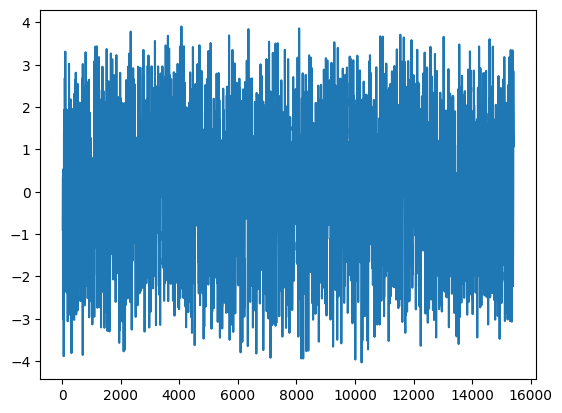

In [10]:
df['z_score'].plot()

trend


/var/folders/sc/br8qxbts38z1106xrqfhwrkc0000gn/T/ipykernel_33771/200490136.py:91: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = mean / stddev * np.sqrt(365 * sr_multiplier)
/var/folders/sc/br8qxbts38z1106xrqfhwrkc0000gn/T/ipykernel_33771/200490136.py:102: RuntimeWarning: invalid value encountered in scalar divide
  'CR': mean * 365 * sr_multiplier / abs(mdd),


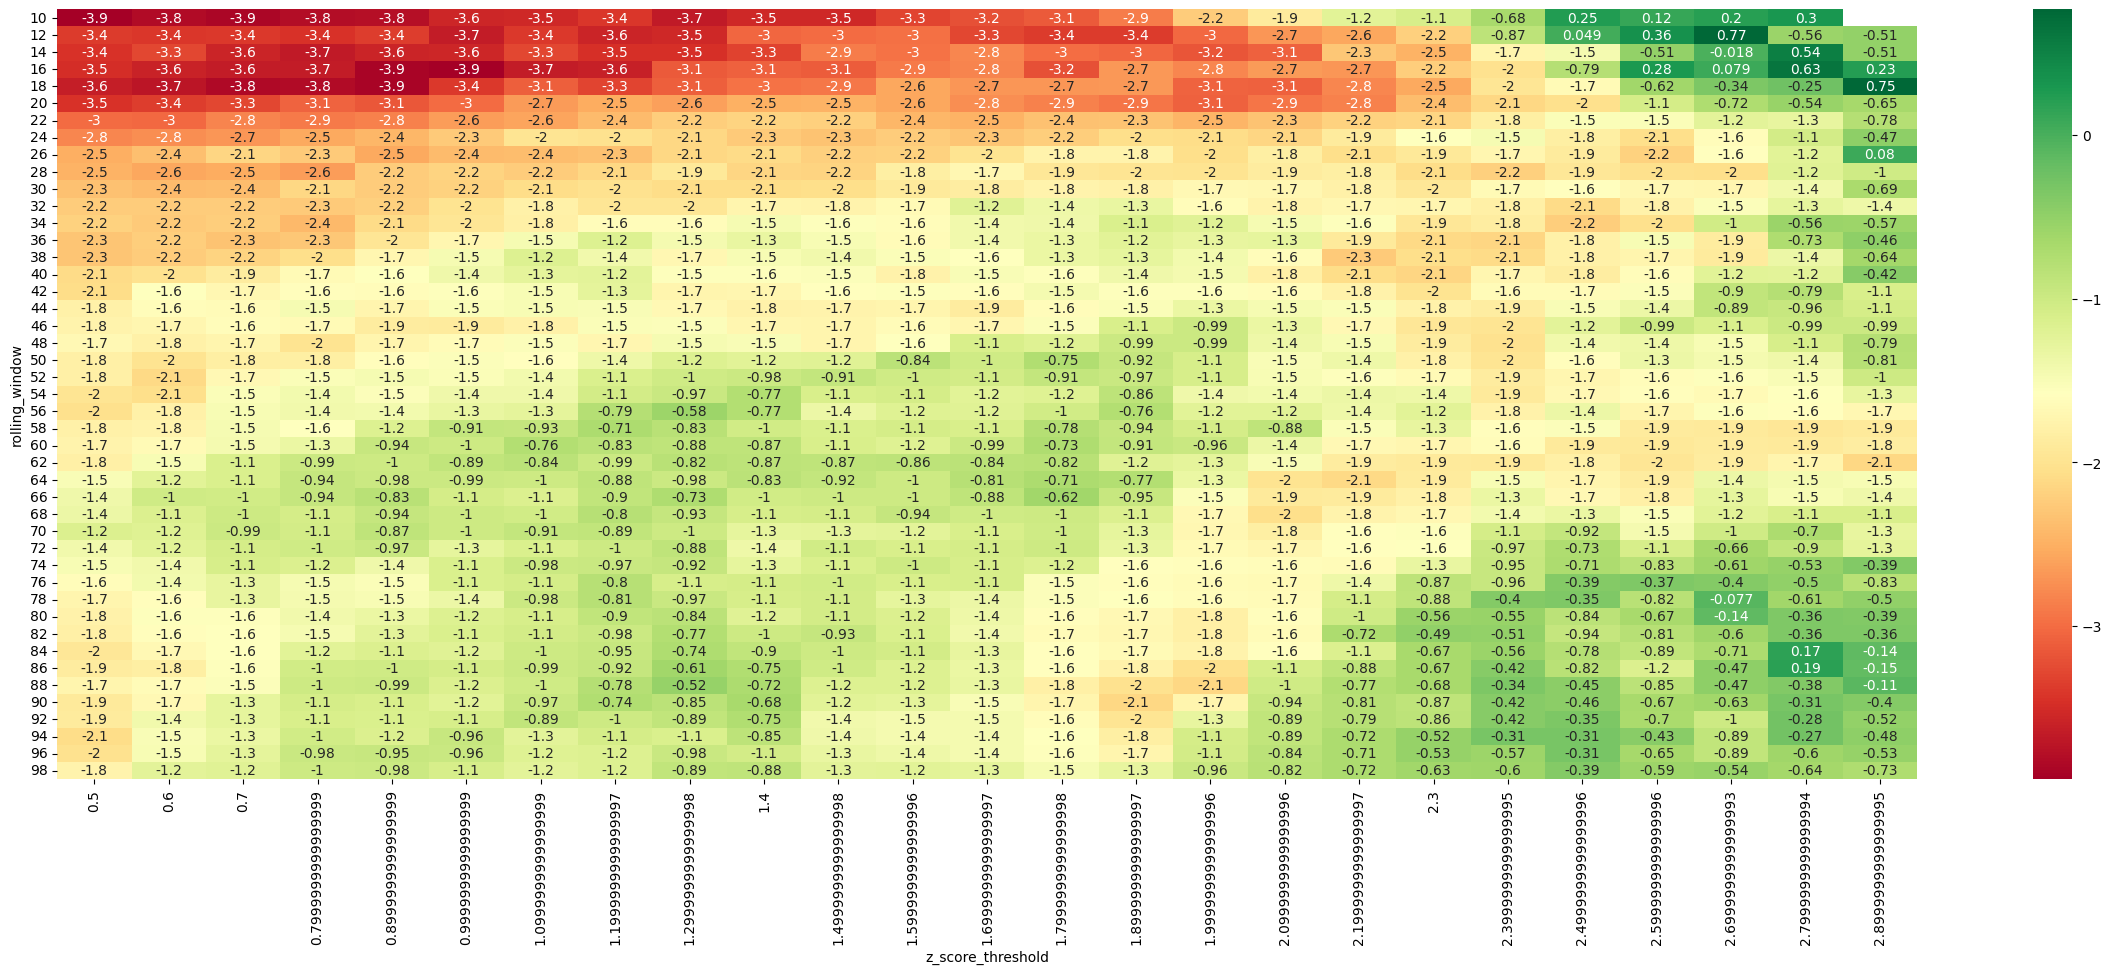

mr


/var/folders/sc/br8qxbts38z1106xrqfhwrkc0000gn/T/ipykernel_33771/200490136.py:91: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = mean / stddev * np.sqrt(365 * sr_multiplier)
/var/folders/sc/br8qxbts38z1106xrqfhwrkc0000gn/T/ipykernel_33771/200490136.py:102: RuntimeWarning: invalid value encountered in scalar divide
  'CR': mean * 365 * sr_multiplier / abs(mdd),


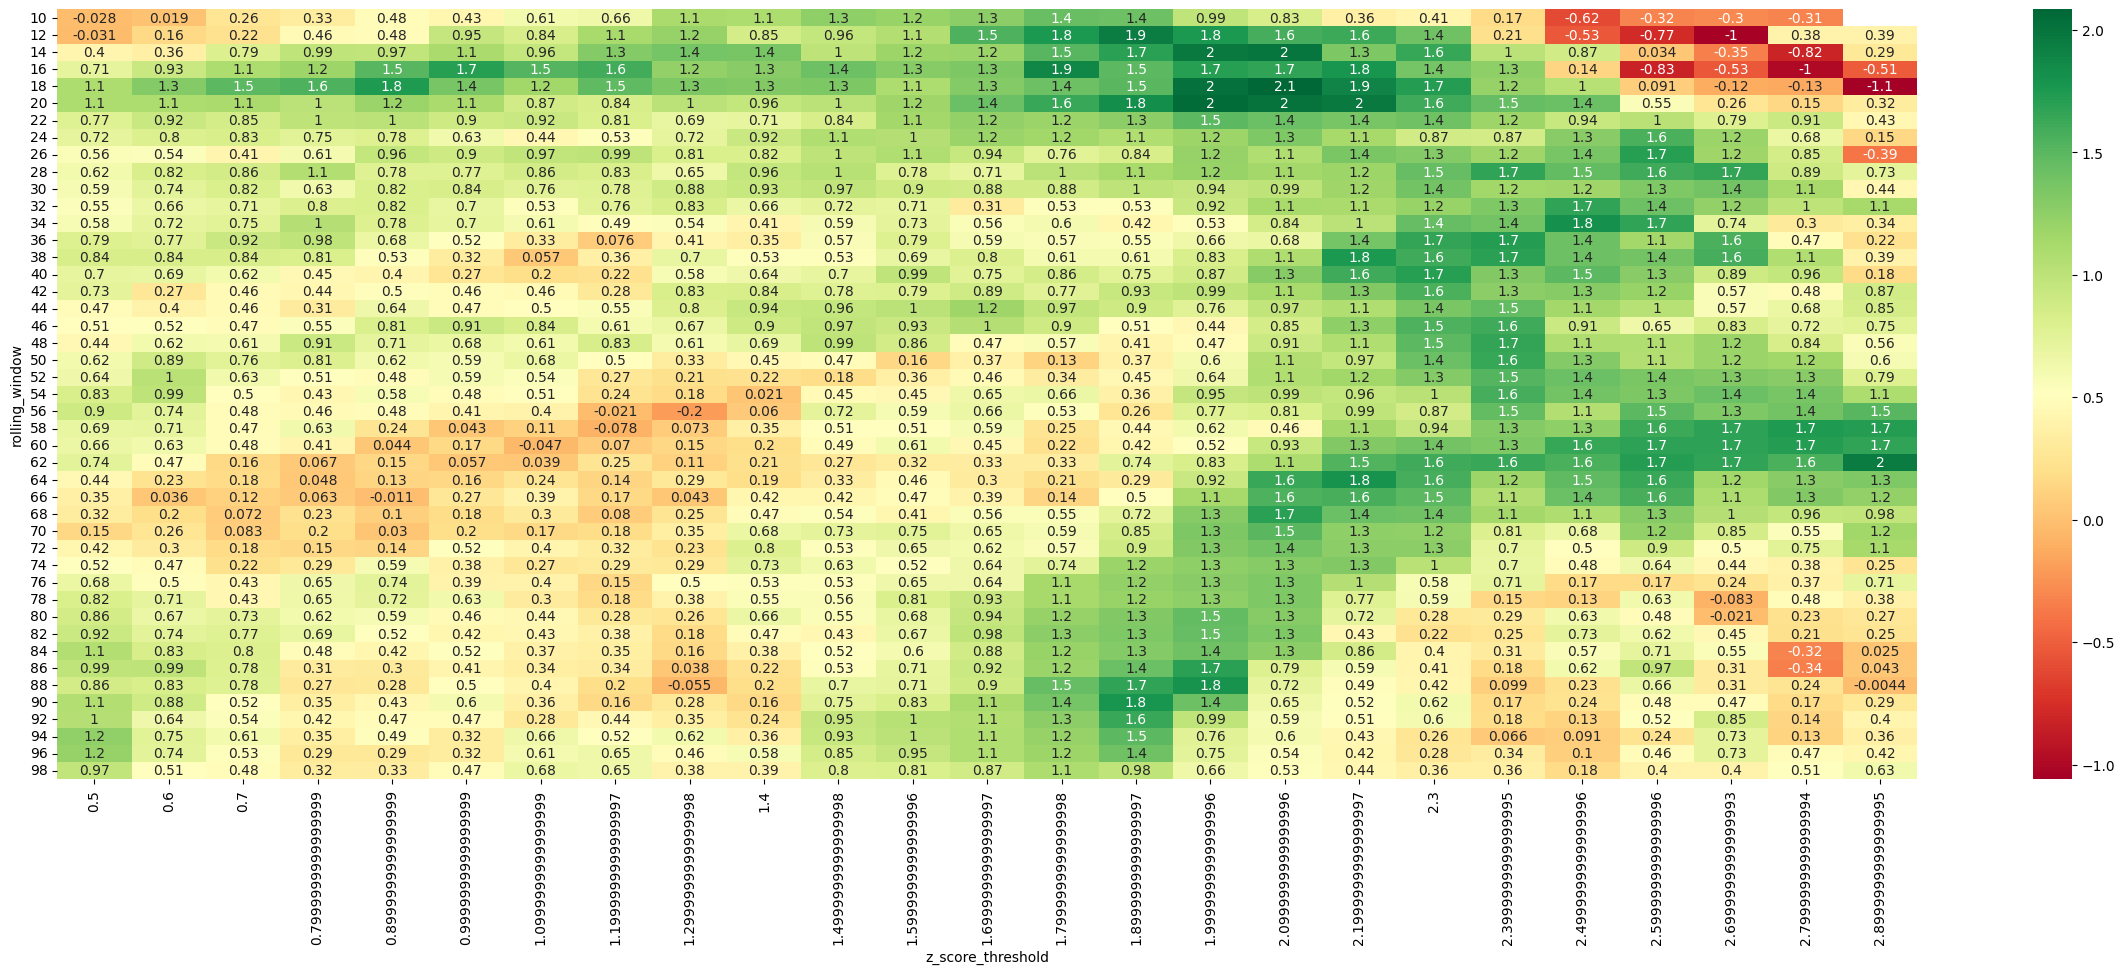

In [55]:
# loop all params needed to backtest 
rolling_window_array = np.arange(10, 100, 2)
z_score_threshold_array = np.arange(0.5, 3, 0.1)
backtest_mode_arr = ["trend", "mr"]
for backtest_mode in backtest_mode_arr:
    print(backtest_mode)
    all_result = []
    for rolling_window in rolling_window_array:
        for z_score_threshold in z_score_threshold_array:
            backtest_1 = backtesting(rolling_window=rolling_window, z_score_threshold=z_score_threshold, sr_multiplier=24, fees=0.06, backtest_mode=backtest_mode)
            # print(backtest_1)
            all_result.append(backtest_1)
    all_sr = pd.DataFrame(all_result)
    df_pivot = all_sr.pivot(index="rolling_window",columns ='z_score_threshold', values="SR")
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Create a heatmap
    plt.figure(figsize=(30, 10))
    sns.heatmap(df_pivot,annot=True, cmap='RdYlGn')
    # Show the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

backtesting(63,2.2,24,0.06,'mr')

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df.index, df['cumu'], label='Cumu PnL', color='blue')
ax1.set_xlabel('Time', color='black')
ax1.set_ylabel('Cumu PnL', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.tick_params(axis='x', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(df.index, df['close_y'], label='Close Price', color='black')
ax2.set_ylabel('Close Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.suptitle('Backtest Result Cumulative PnL and Close Price', color='black')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), frameon=False, fontsize=10, title_fontsize='13', title='Legend')
ax1.grid(True)

plt.show()